In [1]:
from torch.utils.data import DataLoader, Dataset
import os
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt

# Make a database of faces using DataLoader
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform= None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)
        self.labels = [os.path.splitext(filename)[0] for filename in os.listdir(root_dir)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.root_dir, self.images[idx]))
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_label(self):
        return self.labels[0]

    def get_image(self, idx):
        return self.images[idx]

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
transformers = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Grayscale(num_output_channels=1),
                            transforms.Resize((256, 256)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))
                            ])

In [3]:
dataset = FaceDataset("images",
                      transform=transformers)

In [4]:
dataset.images

['An.jpg',
 'Hoang Anh.jpg',
 'Minh.jpg',
 'Nam.jpg',
 'Phuc.jpg',
 'Thong.jpg',
 'Viet.jpg']

In [5]:
labels = dataset.labels
labels

['An', 'Hoang Anh', 'Minh', 'Nam', 'Phuc', 'Thong', 'Viet']

In [6]:
for x,y in dataset:
    print(x.shape, y)
    #plt.imshow(cv2.cvtColor(x.permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB))

torch.Size([1, 256, 256]) An
torch.Size([1, 256, 256]) Hoang Anh
torch.Size([1, 256, 256]) Minh
torch.Size([1, 256, 256]) Nam
torch.Size([1, 256, 256]) Phuc
torch.Size([1, 256, 256]) Thong
torch.Size([1, 256, 256]) Viet


In [7]:
import torch

In [8]:
len(dataset)

7

In [9]:
dataloader = DataLoader(dataset, batch_size=len(dataset))

In [10]:
tensor_dataset = next(iter(dataloader))[0]

In [11]:
a,b = next(iter(dataloader))

In [12]:
a.shape

torch.Size([7, 1, 256, 256])

In [13]:
b

('An', 'Hoang Anh', 'Minh', 'Nam', 'Phuc', 'Thong', 'Viet')

In [14]:
tensor_dataset.shape

torch.Size([7, 1, 256, 256])

In [15]:
tensor_dataset.shape

torch.Size([7, 1, 256, 256])

In [16]:
next(iter(dataloader))[1]

('An', 'Hoang Anh', 'Minh', 'Nam', 'Phuc', 'Thong', 'Viet')

In [17]:
import torch.nn as nn

In [18]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [19]:
siamese_model = torch.load("resources/siamese_16.pth",map_location=torch.device('cpu'))

In [20]:
import torch.onnx 

#Function to Convert to ONNX 
def Convert_ONNX(): 

    # set the model to inference mode 
    siamese_model.eval() 

    # Let's create a dummy input tensor  
    dummy_input = (torch.randn(7, 1, 256, 256, requires_grad=True),
                     torch.randn(2, 1, 256, 256, requires_grad=True))

    # Export the model   
    torch.onnx.export(siamese_model,         # model being run 
         dummy_input,       # model input (or a tuple for multiple inputs) 
         "Siamese_16.onnx",       # where to save the model  
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=10,    # the ONNX version to export the model to 
         do_constant_folding=True,  # whether to execute constant folding for optimization 
         input_names = ['modelInput1', 'modelInput2'],   # the model's input names 
         output_names = ['modelOutput1', 'modelOutput2'], # the model's output names 
         dynamic_axes={'modelInput1' : {0 : 'batch_size_1'},
                        'modelInput2': {0: 'batch_size_2'},    # variable length axes 
                                'modelOutput1' : {0 : 'batch_size_1'},
                                'modelOutput2': {0: 'batch_size_2'}}) 
    print(" ") 
    print('Model has been converted to ONNX')

In [21]:
siamese_model.eval()
Convert_ONNX()

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

 
Model has been converted to ONNX


In [22]:
import onnx

onnx_model = onnx.load("Siamese_16.onnx")
onnx.checker.check_model(onnx_model)

In [23]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("Siamese_16.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [24]:
with torch.inference_mode():
    output1, output2 = siamese_model(tensor_dataset, tensor_dataset)


In [25]:
output1.shape

torch.Size([7, 16])

In [26]:
output2.shape

torch.Size([7, 16])

In [27]:
def recognize_id(database, frame, labels):
    dist_matrix = torch.cdist(torch.Tensor(database), torch.Tensor(frame), p=2)
    argmin_matrix = torch.argmin(dist_matrix, dim=0)
    min_value = torch.min(dist_matrix, dim=0)[0].item()
    name = labels[argmin_matrix]
    return name, min_value

In [28]:
import torch

# define matrices A and B
A = torch.randn(10, 2)
print(A)
B = torch.randn(5, 2)
print(B)

# calculate pairwise distance between rows of A and B
distances = torch.cdist(A, B)
print(distances)

# distances is a (mxn) matrix containing the pairwise distances
distances.shape

tensor([[-0.6664, -2.2407],
        [ 1.2467,  2.5224],
        [ 0.8420,  0.6635],
        [-0.2800, -0.5793],
        [-0.0927, -2.2822],
        [ 0.3621, -0.9566],
        [-0.7113, -0.2902],
        [-0.1525, -0.3485],
        [-0.0165,  1.2058],
        [-0.9112,  0.2962]])
tensor([[-0.7863, -0.3796],
        [ 0.2807, -0.3325],
        [ 0.4814, -0.4152],
        [ 1.0412,  1.3819],
        [ 0.0541,  1.2694]])
tensor([[1.8649, 2.1303, 2.1563, 4.0049, 3.5833],
        [3.5433, 3.0139, 3.0357, 1.1589, 1.7299],
        [1.9338, 1.1432, 1.1374, 0.7456, 0.9940],
        [0.5443, 0.6126, 0.7789, 2.3647, 1.8787],
        [2.0251, 1.9852, 1.9533, 3.8356, 3.5547],
        [1.2853, 0.6294, 0.5544, 2.4351, 2.2472],
        [0.1167, 0.9929, 1.1992, 2.4222, 1.7373],
        [0.6345, 0.4335, 0.6375, 2.1023, 1.6311],
        [1.7624, 1.5667, 1.6957, 1.0723, 0.0950],
        [0.6872, 1.3475, 1.5638, 2.2340, 1.3708]])


torch.Size([10, 5])

In [29]:
def extract_image_by_bounding_box(image, x_min, y_min, width, height):
    return torch.Tensor(image[y_min:y_min+height, x_min:x_min+width]).permute(2, 0, 1)

In [30]:
import time

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(480, 848, 3)
0.3340129852294922 0.3252575099468231 0.3221055865287781 0.5690205097198486
torch.Size([1, 1, 256, 256])
In ONNX: 
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
In PyTorch: 
Time ONNX:  0.03727388381958008
Time PyTorch:  0.06450271606445312
torch.Size([1, 256, 256])


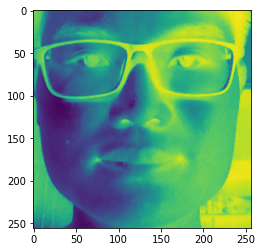

In [31]:
import cv2
import mediapipe as mp
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

with mp_face_detection.FaceDetection(
    model_selection=0, min_detection_confidence=0.5) as face_detection:
    image = cv2.imread("test_images/test_image.jpg",1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape)
    plt.imshow(image)
    results = face_detection.process(image)
    if results.detections:
        faces = torch.Tensor([])
        for detection in results.detections:
            xmin = detection.location_data.relative_bounding_box.xmin
            ymin = detection.location_data.relative_bounding_box.ymin
            width = detection.location_data.relative_bounding_box.width
            height = detection.location_data.relative_bounding_box.height
            print(xmin, ymin, width, height)

            # Extract the face from the image
            face = extract_image_by_bounding_box(image,
                                                int(xmin * image.shape[1]),
                                                int(ymin * image.shape[0]),
                                                int(width * image.shape[1]),
                                                int(height * image.shape[0]))
            # Add the face into faces
            face = transformers(face)
            plt.imshow(face.permute(1, 2, 0))
            faces = torch.cat((faces, face), dim=0)
            if face.ndim == 3:
                face = face.unsqueeze(0)
            print(face.shape)

            print("In ONNX: ")
            time1 = time.time()
            ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tensor_dataset),
                        ort_session.get_inputs()[1].name: to_numpy(face)}
            output_1, output_2 = ort_session.run(None, ort_inputs)
            print(type(output_1), type(output_2))
            id, dist = recognize_id(output_1, output_2, labels)
            time2 = time.time()

            print("In PyTorch: ")
            with torch.inference_mode():
                output_1, output_2 = siamese_model(tensor_dataset, face)
            id, dist = recognize_id(output_1, output_2, labels)
            time3 = time.time()

            print("Time ONNX: ", time2 - time1)
            print("Time PyTorch: ", time3 - time2)

            
            
        print(faces.shape)

In [32]:
output1, output2 = siamese_model(tensor_dataset, face)

In [33]:
print(recognize_id(output1, output2, labels))

('An', 0.34390872716903687)


## Testing

In [49]:
import cv2
import mediapipe as mp
import os
import torch

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
threshold = 0.8

'''name = "Hoang Anh"
# Make directory
if not os.path.exists(f"images/{name}"):
    os.makedirs(f"images/{name}")'''

def extract_image_by_bounding_box(image, x_min, y_min, width, height) -> torch.Tensor:
    return torch.Tensor(image[y_min:y_min+height, x_min:x_min+width])

def face_detection(detector, image):
    results = detector.process(image)
    # Get the bounding box
    if results.detections:
        for detection in results.detections:
            xmin = int(detection.location_data.relative_bounding_box.xmin * image.shape[1])
            ymin = int(detection.location_data.relative_bounding_box.ymin * image.shape[0])
            width = int(detection.location_data.relative_bounding_box.width * image.shape[1])
            height = int(detection.location_data.relative_bounding_box.height * image.shape[0])
            xmin, ymin = max(0, xmin), max(0, ymin)

            # Extract the face from the image
            face = extract_image_by_bounding_box(image, xmin, ymin, width, height)
            # Add the face into faces
            face = transformers(face.permute(2, 0, 1))
            if face.ndim == 3:
                face = face.unsqueeze(0)

            # Recognize the face (PyTorch)
            '''with torch.inference_mode():
                output_1, output_2 = siamese_model(tensor_dataset, face)'''

            # Recognize the face (ONNX)
            ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tensor_dataset),
                        ort_session.get_inputs()[1].name: to_numpy(face)}
            output_1, output_2 = ort_session.run(None, ort_inputs)

            id, dist = recognize_id(output_1, output_2, labels)

            # Draw the bounding box
            draw_boxes(image, xmin, ymin, width, height, id, dist, threshold) 

        return results, faces
    else:
        return results, None

def draw_boxes(image, xmin, ymin, width, height, name, dist, threshold) -> None:
    start_point = (xmin, ymin)
    end_point = (xmin+width, ymin+height)
    name = name if dist < threshold else "Unknown"
    color = (36,255,12) if dist < threshold else (255,0,0)
    image = cv2.rectangle(image, start_point, end_point, color, 1)
    image = cv2.putText(image, f"{name} {'{:.2f}'.format(dist)}", (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

onnx_fpses = []
# For webcam input:
def main():
    cap = cv2.VideoCapture(0)
    # used to record the time when we processed last frame
    prev_frame_time = 0
  
    # used to record the time at which we processed current frame
    new_frame_time = 0
    with mp_face_detection.FaceDetection(
            model_selection=0, min_detection_confidence=0.5) as detector:
        i = 0
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Ignoring empty camera frame.")
                # If loading a video, use 'break' instead of 'continue'.
                continue

            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results, face = face_detection(detector, image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # time when we finish processing for this frame
            new_frame_time = time.time()
        
            # Calculating the fps
        
            # fps will be number of frame processed in given time frame
            # since their will be most of time error of 0.001 second
            # we will be subtracting it to get more accurate result
            fps = 1/(new_frame_time-prev_frame_time)
            prev_frame_time = new_frame_time
        
            # converting the fps into integer
            '''fps = int(fps)
            onnx_fpses.append(fps)'''

            cv2.imshow('MediaPipe Face Detection', image)
            if cv2.waitKey(5) & 0xFF == 27:
                break
            '''i += 1
            if i == 100:
                break'''
    cap.release()

main()


: 

In [67]:
torch_fpses

[0,
 12,
 14,
 11,
 17,
 15,
 15,
 15,
 15,
 15,
 12,
 11,
 12,
 12,
 11,
 12,
 10,
 9,
 10,
 11,
 9,
 11,
 11,
 12,
 9,
 10,
 9,
 9,
 10,
 11,
 10,
 10,
 8,
 9,
 9,
 4,
 10,
 10,
 12,
 12,
 12,
 10,
 9,
 9,
 10,
 10,
 11,
 10,
 10,
 10,
 9,
 9,
 10,
 9,
 10,
 9,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 11,
 11,
 10,
 11,
 13,
 12,
 11,
 10,
 10,
 9,
 9,
 10,
 9,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 10,
 11,
 11,
 10,
 11,
 10,
 10,
 10,
 11,
 10,
 10,
 10,
 11,
 10,
 11,
 10,
 10]

In [56]:
onnx_fpses

[0,
 24,
 24,
 23,
 12,
 19,
 22,
 20,
 20,
 22,
 18,
 22,
 22,
 21,
 21,
 21,
 19,
 19,
 19,
 21,
 15,
 18,
 20,
 19,
 15,
 15,
 17,
 16,
 17,
 15,
 14,
 18,
 16,
 15,
 16,
 16,
 16,
 14,
 14,
 16,
 19,
 15,
 22,
 19,
 15,
 15,
 19,
 15,
 15,
 14,
 13,
 19,
 19,
 20,
 19,
 15,
 16,
 15,
 19,
 16,
 14,
 15,
 17,
 16,
 22,
 17,
 19,
 18,
 19,
 15,
 19,
 15,
 19,
 16,
 16,
 15,
 13,
 17,
 19,
 16,
 17,
 18,
 24,
 18,
 18,
 15,
 16,
 18,
 19,
 20,
 18,
 19,
 14,
 19,
 18,
 19,
 16,
 21,
 23,
 21]

## Compare Torch and ONNX

In [68]:
len(torch_fpses), len(onnx_fpses)

(100, 100)

In [69]:
import pandas as pd

df = pd.DataFrame({'PyTorch': torch_fpses, 'ONNX': onnx_fpses})

In [76]:
import plotly.express as px

px.line(df, x=range(100), y=df.columns[:2], title='FPS Comparison between PyTorch and ONNX Runtime of Face Recognition',
        labels={'x': 'Frame', 'value': 'FPS'})

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\asyncio\selector_events.py", line 115, in _read_from_self
 

: 

True


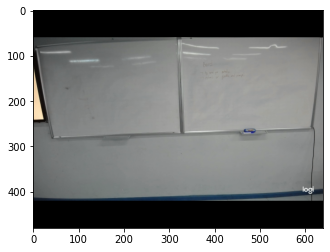

In [54]:
cap = cv2.VideoCapture(2)
ret, frame = cap.read()
print(ret)
cap.release()
plt.imshow(frame)